<a href="https://colab.research.google.com/github/pors/dronelab/blob/main/posts/mnist-basics/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Under the Hood: Training a Digit Classifier

::: {.callout-note}
This notebook is a copy of chapter four of the fastai book [Under the Hood: Training a Digit Classifier](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb){target="_blank"}. 

I added and removed code and markdown here and there reflecting my own understanding of the topic. Not very interesting (aka boring) for 99+% of you, it is mostly for my own reference. My approach here is to work through the original notebook, and if I don't understand something fully, I dive into it a bit. My comments are marked with <mark>\<mark\>...\</mark\></mark>.

For drone related stuff, see the [Code, Fly & AI Series](../../series/index.qmd).
:::

## Pixels: The Foundations of Computer Vision

In [1]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
#hide
Path.BASE_PATH = path

In [5]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [9]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

> jargon: Baseline: A simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model. Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset. Ideally, try both of these!

<mark>\<mark\>I love this advice ^^^. I'll try to follow it as much as possible.\</mark\></mark>

In [10]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

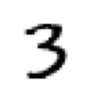

In [11]:
show_image(three_tensors[1]);

In [12]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [13]:
len(stacked_threes.shape)

3

In [14]:
stacked_threes.ndim

3

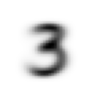

In [15]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

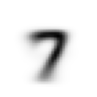

In [16]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

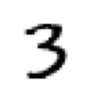

In [17]:
a_3 = stacked_threes[1]
show_image(a_3);

There are two main ways data scientists measure distance in this context:

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*.


In [18]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [19]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [20]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

> S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

## Computing Metrics Using Broadcasting

In [23]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [24]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

<mark>\<mark\>This tuple `(-1,-2)` as an argument for the `mean()` method is not directly clear to me, so let's have a look at the docs:\</mark\></mark>

In [41]:
?torch.mean

Docstring:
mean(input, *, dtype=None) -> Tensor

Returns the mean value of all elements in the :attr:`input` tensor.

Args:
    input (Tensor): the input tensor.

Keyword args:
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        If specified, the input tensor is casted to :attr:`dtype` before the operation
        is performed. This is useful for preventing data type overflows. Default: None.

Example::

    >>> a = torch.randn(1, 3)
    >>> a
    tensor([[ 0.2294, -0.5481,  1.3288]])
    >>> torch.mean(a)
    tensor(0.3367)

.. function:: mean(input, dim, keepdim=False, *, dtype=None, out=None) -> Tensor
   :noindex:

Returns the mean value of each row of the :attr:`input` tensor in the given
dimension :attr:`dim`. If :attr:`dim` is a list of dimensions,
reduce over all of them.


If :attr:`keepdim` is ``True``, the output tensor is of the same size
as :attr:`input` except in the dimension(s) :attr:`dim` where it is of size 1.
Otherwise, :attr

<mark>\<mark\>So the tuple represents a list of dimensions to reduce. In our case the last and second last dimension, which are the dimensions that contain the image pixel values (and the only two dimensions). In other words, this method calculates the average over all elements in the 24x24 matrix.\</mark\></mark>

In [34]:
(a_3-mean3).shape

torch.Size([28, 28])

In [37]:
sm = (a_3-mean3).abs().sum()
avg = sm / (a_3.shape[0] * a_3.shape[1])
avg

tensor(0.1114)

<mark>\<mark\>Same result!\</mark\></mark>

In [38]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

<mark>\<mark\>So here we did the same, but as the first argument we pass a whole stack of images from the validation set. What happened? This works because of a feature called broadcasting. Let's dive into that:\</mark\></mark>

In [ ]:
print(f"valid_3_tens.shape: {valid_3_tens.shape}")
print(f"mean3.shape: {mean3.shape}")
diff = (valid_3_tens-mean3)
diff.shape

valid_3_tens.shape: torch.Size([1010, 28, 28])
mean3.shape: torch.Size([28, 28])


torch.Size([1010, 28, 28])

<mark>\<mark\>`valid_3_tens` has shape `[1010, 28, 28]`, and `mean3` has shape `[28, 28]`. When we subtract them we don't get an error, but a tensor with shape `[1010, 28, 28]`.\</mark\></mark>

<mark>\<mark\>So the broadcasting feature automatically expands the shape of `mean3` to `[1010, 28, 28]` so that it can be subtracted from `valid_3_tens`. There is a couple of conditions that need to be met for this to made possible. Time to experiment a bit with the help of Gemini:\</mark\></mark>

> Broadcasting is PyTorch's way of making operations work between tensors of different but compatible shapes. Instead of you writing explicit loops or manually reshaping/copying data, PyTorch does it conceptually (and efficiently in C++/CUDA).
>
> The Core Idea: Pretend the smaller tensor is expanded (like stretching or copying) to match the shape of the larger tensor, then perform the operation elementwise. Crucially, no actual memory duplication happens.
>
> Rules for Compatibility: PyTorch compares the shapes of two tensors elementwise, starting from the trailing dimensions (the rightmost ones) and working backward. Two dimensions are compatible if:
>
>1. They are equal.
>2. One of them is 1.
>
> If these conditions aren't met for any dimension pair, the tensors are not broadcast-compatible, and you'll get an error. If one tensor runs out of dimensions during the comparison (e.g., comparing a 3D tensor to a 2D tensor), dimensions of size 1 are assumed at the beginning of its shape.

<mark>\<mark\>Now that we know that, we can see that in our example, the two rightmost dimensions have the same size [28, 28], and then the mean3 tensor runs out of dimensions, so it is turned into [1, 28, 28], which makes it compatible for broadcasting. Subsequently the mean3 tensor is expanded into [1010, 28, 28], by repeating the same data 1010 times, so we can subtract the two tensors.\</mark\></mark>

<mark>\<mark\>Let's play a bit with that...\</mark\></mark>

In [51]:
# Create a tensor A with shape (5, 1, 4)
A = torch.zeros(5, 1, 4)
# Create a tensor B with shape (5, 3, 1)
B = torch.ones(5, 3, 1)
# Create a tensor C with shape (3, 4)
C = torch.rand(3, 4)

# Can we add A and B?
try:
    result = A + B
    print("A + B result shape:", result.shape)
except RuntimeError as e:
    print(f"Error adding A and B: {e}")
# Can we add A and C?
try:
    result = A + C
    print("A + C result shape:", result.shape)
except RuntimeError as e:
    print(f"Error adding A and C: {e}")
# Can we add B and C?
try:
    result = B + C
    print("B + C result shape:", result.shape)
except RuntimeError as e:
    print(f"Error adding B and C: {e}")
    
    

A + B result shape: torch.Size([5, 3, 4])
A + C result shape: torch.Size([5, 3, 4])
B + C result shape: torch.Size([5, 3, 4])


<mark>\<mark\>I think I've got that down now!\</mark\></mark>

In [52]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [53]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [54]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [55]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated below, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

![Gradient descent](./gradient-descent.png)

There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this book. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

In [57]:
def f(x): return x**2

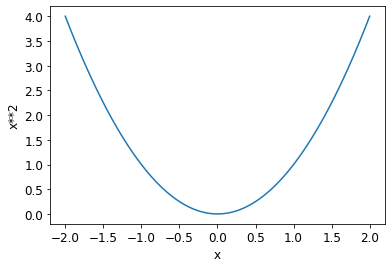

In [ ]:
plot_function(f, 'x', 'x**2')

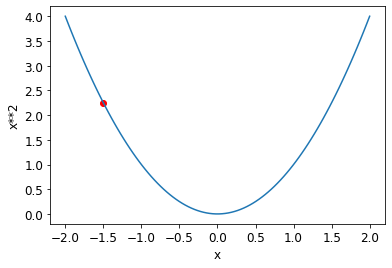

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

<img alt="A graph showing the squared function with the slope at one point" width="400" src="https://github.com/fastai/fastbook/blob/master/images/grad_illustration.svg?raw=1"/>

<img alt="An illustration of gradient descent" width="400" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_perfect.svg?raw=1"/>

### Calculating Gradients

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.


First, let's pick a tensor value which we want gradients at:

In [58]:
xt = tensor(3.).requires_grad_()

In [59]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [60]:
yt.backward()

In [61]:
xt.grad

tensor(6.)

In [62]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [63]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [64]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

w -= gradient(w) * lr

### An End-to-End SGD Example

In [65]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

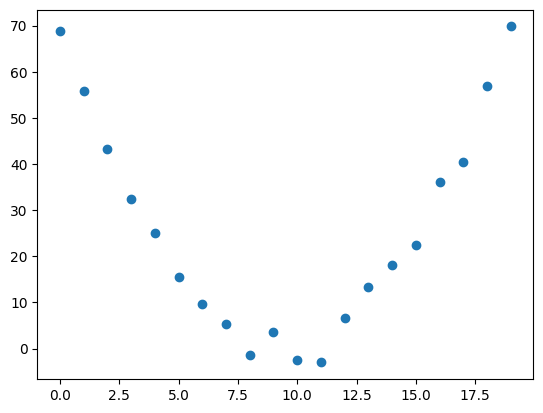

In [66]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [67]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [68]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [71]:
params = torch.randn(3).requires_grad_()

#### Step 2: Calculate the predictions

In [72]:
preds = f(time, params)

In [73]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

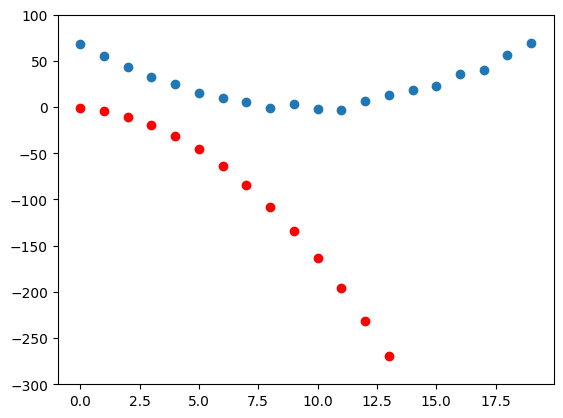

In [74]:
show_preds(preds)

#### Step 3: Calculate the loss

In [75]:
loss = mse(preds, speed)
loss

tensor(82827.6641, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [76]:
loss.backward()
params.grad

tensor([-96139.7500,  -6190.7744,   -445.6926])

In [77]:
params.grad * 1e-5

tensor([-0.9614, -0.0619, -0.0045])

In [78]:
params

tensor([-1.4608, -1.6226, -1.2073], requires_grad=True)

#### Step 5: Step the weights.

In [79]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [80]:
preds = f(time,params)
mse(preds, speed)

tensor(16233.4893, grad_fn=<MeanBackward0>)

And take a look at the plot:

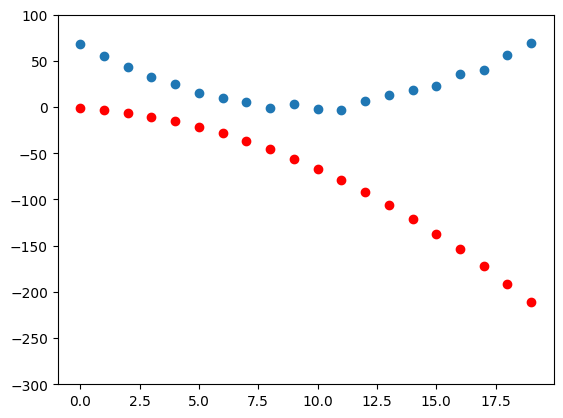

In [81]:
show_preds(preds)

In [82]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

<mark>\<mark\>Remember from my [previous post](../how-does-a-neural-net-really-work/) that we had to do this: `with torch.no_grad(): abc -= abc.grad*0.01`, to make sure PyTorch won't track this operation for calculating the gradient? So, why not here? Because it sets the result directly on the `data` property of `params`. That apparently prevents the gradient function tracker to ignore this operation.\</mark\></mark>

#### Step 6: Repeat the process

In [83]:
for i in range(10): apply_step(params)

16233.4892578125
3631.822265625
1247.1947021484375
795.9425659179688
710.5438842773438
694.3759765625
691.3086547851562
690.7203369140625
690.6011352539062
690.5706787109375


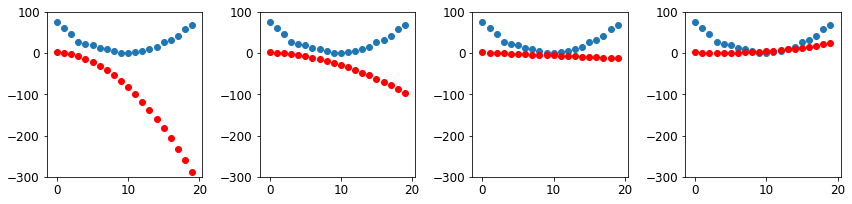

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

## The MNIST Loss Function

In [84]:
stacked_sevens.shape, stacked_threes.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [85]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

<mark>\<mark\>OK, so each image is now a vector of all 28*28 pixels, and dimension 0 basically points to each single image.\</mark\></mark>

In [94]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

<mark>\<mark\>So, `[1]*len(threes) + [0]*len(sevens)` simply creates a vector with all the "labels" (dependent variables). Now what is this `unsqueeze(1)` doing? We have a row of labels, but if we want to match them up with `train_x` we need a column. That is exactly what `unsqueeze(1)` does. Let's play a little bit with that:\</mark\></mark>

In [89]:
labels_list = tensor([1]*10 + [0]*10)
print(f"shape: {labels_list.shape}")
labels_list

shape: torch.Size([20])


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [90]:
labels_list_unsqueezed = labels_list.unsqueeze(1)
print(f"shape: {labels_list_unsqueezed.shape}")
labels_list_unsqueezed

shape: torch.Size([20, 1])


tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

In [91]:
labels_list_unsqueezed0 = labels_list.unsqueeze(0)
print(f"shape: {labels_list_unsqueezed0.shape}")
labels_list_unsqueezed0

shape: torch.Size([1, 20])


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [92]:
labels_list_unsqueezed0 = labels_list[:, None]
print(f"shape: {labels_list_unsqueezed0.shape}")
labels_list_unsqueezed0

shape: torch.Size([20, 1])


tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

<mark>\<mark\>Ah, look at that! It is the same as the `[:, None]` trick we saw in the previous post!\</mark\></mark>

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [95]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

<mark>\<mark\>So we now have a nice list of tuples of the form: (image vector, label)\</mark\></mark>

In [96]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [97]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [98]:
weights = init_params((28*28,1))

In [99]:
bias = init_params(1)

> jargon: Parameters: The _weights_ and _biases_ of a model. The weights are the `w` in the equation `w*x+b`, and the biases are the `b` in that equation.

In [100]:
(train_x[0]*weights.T).sum() + bias

tensor([9.3344], grad_fn=<AddBackward0>)

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="https://github.com/fastai/fastbook/blob/master/images/matmul2.svg?raw=1" id="matmul"/>

In [101]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 9.3344],
        [ 0.8027],
        [ 7.0013],
        ...,
        [-1.8317],
        [ 3.5838],
        [-4.9083]], grad_fn=<AddBackward0>)

In [102]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [ True]])

In [103]:
corrects.float().mean().item()

0.6630364656448364

In [104]:
with torch.no_grad(): weights[0] *= 1.0001

In [105]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.6630364656448364

In [106]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [107]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [108]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [109]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [110]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [111]:
def sigmoid(x): return 1/(1+torch.exp(-x))

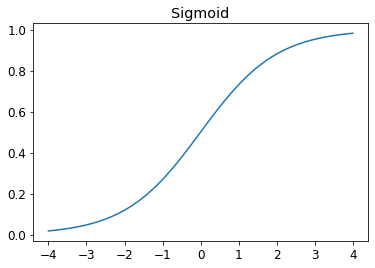

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [112]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [113]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([11,  4,  8,  9, 10]),
 tensor([13,  1,  5,  0, 14]),
 tensor([ 3, 12,  7,  2,  6])]

In [114]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [115]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 22, 12, 20,  9,  6]), ('r', 'w', 'm', 'u', 'j', 'g')),
 (tensor([21,  7, 14, 13,  0, 24]), ('v', 'h', 'o', 'n', 'a', 'y')),
 (tensor([ 3,  8,  4, 16, 19,  5]), ('d', 'i', 'e', 'q', 't', 'f')),
 (tensor([18, 11, 25, 23,  2,  1]), ('s', 'l', 'z', 'x', 'c', 'b')),
 (tensor([10, 15]), ('k', 'p'))]

## Putting It All Together

In [116]:
weights = init_params((28*28,1))
bias = init_params(1)

In [117]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [118]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [119]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [120]:
preds = linear1(batch)
preds

tensor([[0.7288],
        [2.3106],
        [2.0486],
        [1.4359]], grad_fn=<AddBackward0>)

In [121]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.1805, grad_fn=<MeanBackward0>)

In [122]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0212), tensor([-0.1395]))

In [123]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [124]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0424), tensor([-0.2790]))

In [125]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0636), tensor([-0.4185]))

In [126]:
weights.grad.zero_()
bias.grad.zero_();

In [127]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [128]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [129]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [130]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [131]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [132]:
validate_epoch(linear1)

0.7649

In [133]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.8446

In [134]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.9144 0.9369 0.9462 0.9545 0.9589 0.9603 0.9628 0.9638 0.9638 0.9643 0.9657 0.9652 0.9657 0.9677 0.9681 0.9681 0.9696 0.9696 0.9706 0.972 

### Creating an Optimizer

In [135]:
linear_model = nn.Linear(28*28,1)

In [136]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [137]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [138]:
opt = BasicOptim(linear_model.parameters(), lr)

In [139]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [140]:
validate_epoch(linear_model)

0.6292

In [141]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [142]:
train_model(linear_model, 20)

0.4932 0.8052 0.8525 0.917 0.9346 0.9487 0.957 0.9624 0.9658 0.9678 0.9692 0.9717 0.9736 0.9746 0.9761 0.9765 0.9775 0.978 0.978 0.979 

In [143]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7759 0.8603 0.9179 0.9346 0.9516 0.957 0.9634 0.9658 0.9673 0.9697 0.9717 0.9746 0.9751 0.9761 0.977 0.9775 0.978 0.978 0.9785 

In [144]:
dls = DataLoaders(dl, valid_dl)

In [145]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [146]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636803,0.503571,0.495584,00:00
1,0.569794,0.217214,0.807655,00:00
2,0.208501,0.165452,0.851816,00:00
3,0.090031,0.101155,0.914622,00:00
4,0.046536,0.074791,0.935231,00:00
5,0.029671,0.060303,0.948970,00:00
6,0.022822,0.051260,0.956330,00:00
7,0.019821,0.045237,0.962218,00:00
8,0.018322,0.040985,0.965653,00:00
9,0.017435,0.037833,0.968106,00:00


## Adding a Nonlinearity

In [ ]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

<mark>\<mark\>So, the `w1` matrix has 30 rows and 784 columns, which means that it can take a vector of 784 pixel values as input (the image we want to classify), and return a vector of 30 values. The `w2` matrix has 1 row and 30 columns, which means that it can take a vector of 30 values as input, and return a scalar (which is the probability).\</mark\></mark>

<mark>\<mark\>These 30 output activations are synonym to a layer of 30 nodes. Each of these 30 nodes has it's own set of 784 weights that we try to optimize. So more nodes means more possible feature detectors or pattern recognizers that our model can learn. We can think of each of those 30 nodes as becoming specialized in detecting different aspects of what makes a digit look like a "3" versus a "7".\</mark\></mark>

<mark>\<mark\>I like how Claude said it while explaining this to me:\</mark\></mark>

> Here's a helpful way to think about it: imagine you're trying to distinguish between cats and dogs, and you have 30 friends helping you. Each friend specializes in looking for different features - one focuses on ear shape, another on tail length, another on fur texture, and so on. Each friend gives you their opinion (a number between, say, -10 and +10), and then you have to weigh all 30 opinions to make your final decision. That's essentially what your two-layer network is doing.
>
> The beauty is that during training, the network automatically figures out what each of those 30 "friends" should specialize in looking for. You don't have to tell it "node 1, you focus on curves" - it discovers these useful features on its own through the optimization process.

<mark>\<mark\>I was then wondering: what if some or all nodes try to specialize in the same feature? There are two reasons why this is not likely:</mark>

<mark>1. We initialize the weights randomly, so each node starts with a different perspective.</mark>

<mark>2. The optimization process will adjust the weights in such a way that it minimizes the loss function, which means that if two nodes try to learn the same feature, one of them will end up being less effective and will be encouraged to learn something else.\</mark\></mark>

<mark>\<mark\>I still have to think hard to get the matrix juggling down, so let's create a super-tiny net:\</mark\></mark>


In [159]:
# Our tiny network layer
layer = nn.Linear(4, 3)  # 4 inputs (2x2 image flattened), 3 outputs

# Sample 2x2 image
image = tensor([[1.0, 2.0],
                [3.0, 4.0]])

# Flatten the image to a column vector
x = image.flatten()  # x = [1.0, 2.0, 3.0, 4.0] with shape [4]

# The weights and biases are already initialized by nn.Linear
w = layer.weight  # shape [3, 4]
b = layer.bias      # shape [3]

print(f"Weights {w.shape}: {w.data}, Bias {b.shape}: {b.data}")

# Matrix multiplication: w @ x (shape [3,4] @ [4] = [3])
output = w @ x + b
print(f"Output shape: {output.shape}, Output: {output.data}")

# Now apply ReLU activation
output2 = F.relu(output)
print(f"Output after ReLU shape: {output2.shape}, Output: {output2.data}")

# Last layer
layer2 = nn.Linear(3, 1)  # 3 inputs, 1 output
# Weights and biases for the last layer
w2 = layer2.weight  # shape [1, 3]
b2 = layer2.bias      # shape [1]
# Final output
final_output = w2 @ output2 + b2
print(f"Final output shape: {final_output.shape}, Final output: {final_output.data}")
# Final output after sigmoid activation
final_output_sigmoid = torch.sigmoid(final_output)
print(f"Final output after sigmoid shape: {final_output_sigmoid.shape}, Final output: {final_output_sigmoid.data}")

Weights torch.Size([3, 4]): tensor([[ 0.0777,  0.2776,  0.4277,  0.0007],
        [-0.4654, -0.0821,  0.1229,  0.2742],
        [ 0.1707, -0.2651,  0.3052,  0.1164]]), Bias torch.Size([3]): tensor([-0.1928, -0.2575,  0.3110])
Output shape: torch.Size([3]), Output: tensor([1.7258, 0.5783, 1.3328])
Output after ReLU shape: torch.Size([3]), Output: tensor([1.7258, 0.5783, 1.3328])
Final output shape: torch.Size([1]), Final output: tensor([-0.2682])
Final output after sigmoid shape: torch.Size([1]), Final output: tensor([0.4333])


<mark>\<mark>This tiny model is visualized below. The first layer has 3 nodes and the second linear layer has 1 node.\</mark></mark>

![Super-tiny net. Made with [NN-SVG](https://alexlenail.me/NN-SVG/index.html){target="_blank"}](./super-tiny.png)

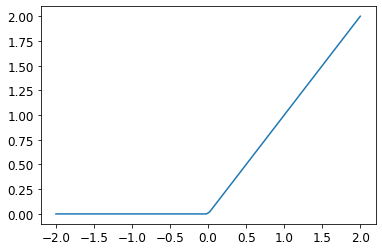

In [ ]:
plot_function(F.relu)

In [160]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [161]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.325859,0.411601,0.504907,00:00
1,0.150409,0.233516,0.798332,00:00
2,0.082649,0.116558,0.913150,00:00
3,0.054023,0.078485,0.940628,00:00
4,0.040843,0.061257,0.954858,00:00
5,0.034143,0.051604,0.963199,00:00
6,0.030300,0.045509,0.965653,00:00
7,0.027805,0.041319,0.967615,00:00
8,0.026009,0.038248,0.968597,00:00
9,0.024617,0.035891,0.969578,00:00


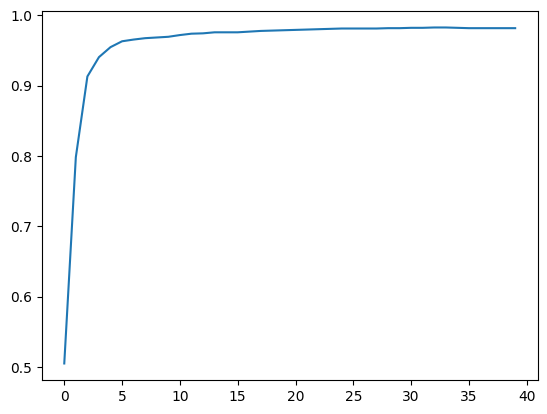

In [163]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [164]:
learn.recorder.values[-1][2]

0.981844961643219

### Going Deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th>epoch</th>
      <th>train_loss</th>
      <th>valid_loss</th>
      <th>accuracy</th>
      <th>time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>0.082135</td>
      <td>0.014342</td>
      <td>0.996565</td>
      <td>02:26</td>
    </tr>
  </tbody>
</table>

## Jargon Recap

Congratulations: you now know how to create and train a deep neural network from scratch! We've gone through quite a few steps to get to this point, but you might be surprised at how simple it really is.

Now that we are at this point, it is a good opportunity to define, and review, some jargon and key concepts.

A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:

- <mark>Activations: Numbers that are calculated (both by linear and nonlinear layers)</mark>
- <mark>Parameters: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)</mark>

We will often talk in this book about activations and parameters. Remember that they have very specific meanings. They are numbers. They are not abstract concepts, but they are actual specific numbers that are in your model. Part of becoming a good deep learning practitioner is getting used to the idea of actually looking at your activations and parameters, and plotting them and testing whether they are behaving correctly.

Our activations and parameters are all contained in *tensors*. These are simply regularly shaped arrays—for example, a matrix. Matrices have rows and columns; we call these the *axes* or *dimensions*. The number of dimensions of a tensor is its *rank*. There are some special tensors:

- Rank zero: scalar
- Rank one: vector
- Rank two: matrix

A neural network contains a number of layers. Each layer is either *linear* or *nonlinear*. We generally alternate between these two kinds of layers in a neural network. Sometimes people refer to both a linear layer and its subsequent nonlinearity together as a single layer. Yes, this is confusing. Sometimes a nonlinearity is referred to as an *activation function*.

| Term | Meaning |
|------|---------|
| ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers. |
| Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch). |
| Forward pass | Applying the model to some input and computing the predictions. |
| Loss | A value that represents how well (or badly) our model is doing. |
| Gradient | The derivative of the loss with respect to some parameter of the model. |
| Backward pass | Computing the gradients of the loss with respect to all model parameters. |
| Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better. |
| Learning rate | The size of the step we take when applying SGD to update the parameters of the model. |

<mark>\<mark\>And that concludes lesson 3 of the course (and chapter 4 of the book) for me. I'll move on with chapter 5 of the book instead of lesson 4 of the course. Let's get all the computer vision stuff done before moving to NLP.\</mark\></mark>